# Transfer learning: training shallow classifiers on embedding models outputs

If you want to adapt BirdNET, Perch, HawkEars, or another foundation model to a new set of classes or a new domain, you'll be doing what machine learning experts call transfer learning. This tutorial demonstrates tranfer learning for PyToch models, but you can do the same with TensorFlow models such as BirdNET and Perch - examples are in a separate notebook `training_birdnet_and_perch.ipynb` since you might need to set your python environment up differently (by installing tensorflow and tensorflow-hub packages).

This notebook shows examples of how to train simple one-layer or multi-layer fully-connected neural networks (aka multi-layer perceptron networks, MLPs) on embedding (aka features) generated by a pre-trained deep learning model. This workflow is called transfer learning because the learned feature extraction of the embedding model is transfered to a new domain. Ghani et al. [1] demonstrated that gobal bird classification models can act as feature extractors that can be used to train shallow classifiers on novel tasks and domains, even when few training samples are available.

Training a shallow classifier on embeddings, rather than training or fine-tuning an entire deep learning model, has three advantages: (1) classifiers can be developed with just a handful of training examples; (2) models fit very quickly, enabling an iterative human-in-the-loop workflow for active learning; (3) any model that generates embeddings can be used as the feature extractor; in particular, compiled models without open-source weights (e.g. BirdNET [2]) can be used as the embedding model.

Users can develop flexible and customizable transfer-learning workflow by generating embeddings then using PyTorch or sklearn directly. This notebook demonstrates both (1) high-level functions and classes in OpenSoundscape that simplify the code needed to perform transfer learning; and (2) examples demonstrating the embedding and model fitting steps explicitly line-by-line.

> Note: to use models from the model zoo, install the bioacoustics_model_zoo as a package in your python environment:

`pip install git+https://github.com/kitzeslab/bioacoustics-model-zoo`

[1] Ghani, B., T. Denton, S. Kahl, H. Klinck, T. Denton, S. Kahl, and H. Klinck. 2023. Global birdsong embeddings enable superior transfer learning for bioacoustic classification. Scientific Reports 13:22876.

[2] Kahl, Stefan, et al. "BirdNET: A deep learning solution for avian diversity monitoring." Ecological Informatics 61 (2021): 101236.


## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

In [1]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install git+https://github.com/kitzeslab/opensoundscape@develop ipykernel==5.5.6 ipython==7.34.0 pillow==9.4.0
  num_workers=0
else:
  #can use >0, e.g. 4, but might need to install the bioacoustics model zoo as a package:
  # `pip install git+https://github.com/kitzeslab/bioacoustics-model-zoo@0.11.0.dev1`
  num_workers=0 

## Setup

### Import needed packages

In [2]:
#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings


/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_76442/267712919.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Set random seeds

Set manual seeds for Pytorch and Python. These essentially "fix" the results of any stochastic steps in model training, ensuring that training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### Download and prepare training data


#### Download example files
Download a set of aquatic soundscape recordings with annotations of _Rana sierrae_ vocalizations

Option 1: run the cell below

- if you get a 403 error, DataDryad suspects you are a bot. Use Option 2. 

Option 2:

- Download and unzip the `rana_sierrae_2022.zip` folder containing audio and annotations from this [public Dryad dataset](https://datadryad.org/stash/dataset/doi:10.5061/dryad.9s4mw6mn3#readme)
- Move the unzipped `rana_sierrae_2022` folder into the current folder

In [4]:
# # Note: the "!" preceding each line below allows us to run bash commands in a Jupyter notebook
# # If you are not running this code in a notebook, input these commands into your terminal instead
# !wget -O rana_sierrae_2022.zip https://datadryad.org/stash/downloads/file_stream/2722802;
# !unzip rana_sierrae_2022;

#### Prepare audio data
See the train_cnn.ipynb tutorial for step-by-step walkthrough of this process, or just run the cells below to prepare a trainig set.

In [ ]:
# Set the current directory to where the folder `rana_sierrae_2022` is located:
dataset_path = Path("./rana_sierrae_2022/")

# let's generate clip labels of 5s duration (to match HawkEars) using the raven annotations
# and some utility functions from opensoundscape
from opensoundscape.annotations import BoxedAnnotations

audio_and_raven_files = pd.read_csv(f"{dataset_path}/audio_and_raven_files.csv")
# update the paths to where we have the audio and raven files stored
audio_and_raven_files["audio"] = audio_and_raven_files["audio"].apply(
    lambda x: f"{dataset_path}/{x}"
)
audio_and_raven_files["raven"] = audio_and_raven_files["raven"].apply(
    lambda x: f"{dataset_path}/{x}"
)

annotations = BoxedAnnotations.from_raven_files(
    raven_files=audio_and_raven_files["raven"],
    audio_files=audio_and_raven_files["audio"],
    annotation_column="annotation",
)
# generate labels for 5s clips, including any labels that overlap by at least 0.2 seconds
labels = annotations.clip_labels(clip_duration=5, min_label_overlap=0.2)

/Users/SML161/opensoundscape/opensoundscape/annotations.py:300: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_annotations_df = pd.concat(all_file_dfs).reset_index(drop=True)


#### Inspect labels

Count number of each annotation type: 

Note that the 'X' label is for when the annotator was uncertain about the identity of a call. Labels A-E denote distinct call types.

In [6]:
labels.sum()

A    512
E    128
D     62
B     24
C     74
X    118
dtype: int64

#### split into training and validation data
We'll just focus on class 'A', the call type with the most annotations. We'll randomly split the clips into training and validation data, acknowledging that this approach does not test the ability of the model to generalize. Since the samples in the training and validation sets could be adjascent 2-second audio clips, good performance could simply mean the model has memorized the training samples, and the validation set has very similar samples. 

In [ ]:
labels_train, labels_val = sklearn.model_selection.train_test_split(labels[["A"]])

## Train shallow classifiers on embedding model outputs

We'll train our classifiers on a small annotated dataset with HawkEars, Perch, and BirdNET as feature extractors.

In [ ]:
import bioacoustics_model_zoo as bmz

hawk = bmz.HawkEars

Using cache found in /Users/SML161/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_0.11.0.dev1


File hgnet1.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet1.ckpt...
File hgnet2.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet2.ckpt...
File hgnet3.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet3.ckpt...
File hgnet4.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet4.ckpt...
File hgnet5.ckpt already exists; skipping download.
Loading model from local checkpoint /Users/SML161/opensoundscape/docs/tutorials/hgnet5.ckpt...


/Users/SML161/opensoundscape/opensoundscape/ml/cnn.py:621: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures module for examples of constructor functions
                    
  warnings.warn(
/Users/SML161/opensoundscape/opensoundscape/ml/cnn.py:64

Create a shallow classifier that we'll train with embeddings as inputs. The input size needs to match the size of the embeddings produced by our embedding model. HawkEars embeddings are vectors of length 2048. 

In [ ]:
clf = MLPClassifier(
    input_size=2048, output_size=labels_train.shape[1], hidden_layer_sizes=()
)

We can run a single function that will embed the training and validation samples, then train the classifier.

This will take a minute or two, since all of the samples need to be embedded with HawkEars.

In [ ]:
emb_train, label_train, emb_val, label_val = fit_classifier_on_embeddings(
    embedding_model=hawk,
    classifier_model=clf,
    train_df=labels_train,
    validation_df=labels_val,
    steps=1000,
    embedding_batch_size=128,
    embedding_num_workers=num_workers,
)

Embedding the training samples without augmentation


  0%|          | 0/8 [00:00<?, ?it/s]

Embedding the validation samples


  0%|          | 0/3 [00:00<?, ?it/s]

Fitting the classifier
Epoch 100/1000, Loss: 0.5505968928337097, Val Loss: 0.551829993724823
val AU ROC: 0.768
val MAP: 0.768
Epoch 200/1000, Loss: 0.503508448600769, Val Loss: 0.5115979313850403
val AU ROC: 0.774
val MAP: 0.774


/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = to

Epoch 300/1000, Loss: 0.48121362924575806, Val Loss: 0.4945080280303955
val AU ROC: 0.778
val MAP: 0.778
Epoch 400/1000, Loss: 0.46753495931625366, Val Loss: 0.4849015772342682
val AU ROC: 0.783
val MAP: 0.783
Epoch 500/1000, Loss: 0.4575219750404358, Val Loss: 0.47844940423965454
val AU ROC: 0.787
val MAP: 0.787
Epoch 600/1000, Loss: 0.4493757486343384, Val Loss: 0.4737447500228882
val AU ROC: 0.790
val MAP: 0.790
Epoch 700/1000, Loss: 0.4423135221004486, Val Loss: 0.47020459175109863
val AU ROC: 0.792
val MAP: 0.792
Epoch 800/1000, Loss: 0.43594419956207275, Val Loss: 0.4675188660621643
val AU ROC: 0.793
val MAP: 0.793
Epoch 900/1000, Loss: 0.4300559461116791, Val Loss: 0.46549251675605774
val AU ROC: 0.795
val MAP: 0.795
Epoch 1000/1000, Loss: 0.4245266020298004, Val Loss: 0.46399158239364624
val AU ROC: 0.796
val MAP: 0.796
Training complete


let's evaluate our shallow classifier on the test set:

In [ ]:
# predict classes with the shallow classifier starting from the embeddings
preds = clf(emb_val.to(torch.device("cpu"))).detach().numpy()

# evaluate with threshold agnostic metrics: MAP and ROC AUC
print(
    f"average precision score: {average_precision_score(label_val,preds,average=None)}"
)
print(f"area under ROC: {roc_auc_score(label_val,preds,average=None)}")

average precision score: 0.7960448728167171
area under ROC: 0.8267195767195767


to visualize the performance, let's plot histograms of classifier logit scores for positive and negative samples

it shows that precision is good for scores above >0 (few negatives get high scores), but recall is only moderate (many positive samples get low scores)

/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


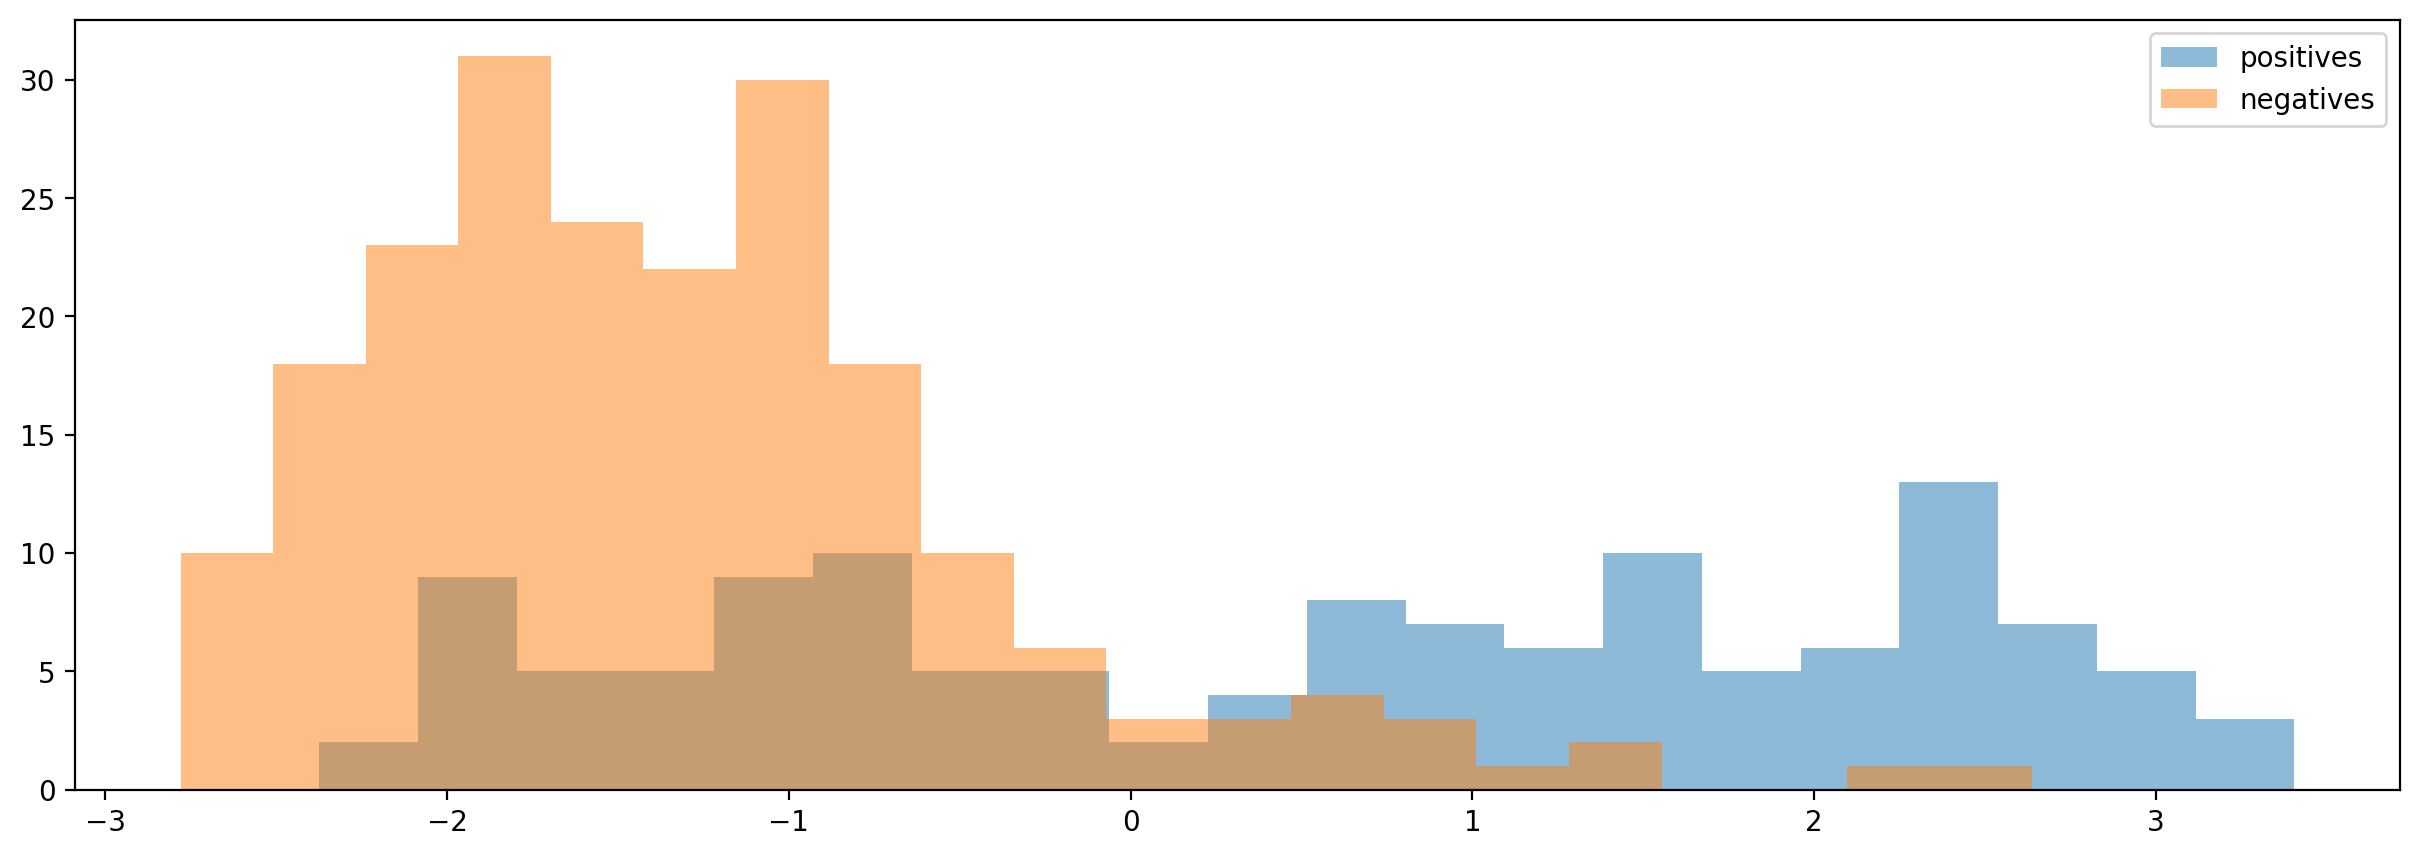

In [ ]:
plt.hist(preds[label_val == 1], bins=20, alpha=0.5, label="positives")
plt.hist(preds[label_val == 0], bins=20, alpha=0.5, label="negatives")
plt.legend()

Alternatively, we can embed the training and validation sets first, then train as many different variants as we want.

(note that the `fit_classifier_on_embeddings` returns the embeddings on the training and validation set, so if you've already run that function you don't need to re-generate the embeddings)

Generally, embedding may take a while for large datasets, but training the shallow classifier will be very fast because the network is small and there is no preprocessing or data loading. 

For example, here we compare fitting classifiers with one or two hidden layers on the same data:

In [14]:
# uncomment the lines below to generate training and validation set embeddings, if you don't have them from the previous cells
# emb_train = hawk.embed(labels_train, return_dfs=False, batch_size=128, num_workers=num_workers)
# emb_val = hawk.embed(labels_val, return_dfs=False, batch_size=128, num_workers=num_workers)

In [ ]:
# define classifier with one hidden layer, and fit
classifier_model_1 = MLPClassifier(2048, 1, hidden_layer_sizes=(100,))
classifier_model_1.fit(
    emb_train, labels_train.values, emb_val, labels_val.values, steps=1000
)

# define classifier with two hidden layers, and fit
classifier_model_2 = MLPClassifier(2048, 1, hidden_layer_sizes=(100, 100))
classifier_model_2.fit(
    emb_train, labels_train.values, emb_val, labels_val.values, steps=1000
)

/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 0.43477728962898254, Val Loss: 0.4654878079891205
val AU ROC: 0.795
val MAP: 0.795
Epoch 200/1000, Loss: 0.36520084738731384, Val Loss: 0.47021692991256714
val AU ROC: 0.791
val MAP: 0.791
Epoch 300/1000, Loss: 0.2947371006011963, Val Loss: 0.5176641345024109
val AU ROC: 0.779
val MAP: 0.779
Epoch 400/1000, Loss: 0.22931015491485596, Val Loss: 0.5908443927764893
val AU ROC: 0.764
val MAP: 0.764
Epoch 500/1000, Loss: 0.17564012110233307, Val Loss: 0.6850444078445435
val AU ROC: 0.753
val MAP: 0.753
Epoch 600/1000, Loss: 0.13606344163417816, Val Loss: 0.7922593355178833
val AU ROC: 0.744
val MAP: 0.744
Epoch 700/1000, Loss: 0.10693871974945068, Val Loss: 0.9060013294219971
val AU ROC: 0.739
val MAP: 0.739
Epoch 800/1000, Loss: 0.08502118289470673, Val Loss: 1.0221915245056152
val AU ROC: 0.734
val MAP: 0.734
Epoch 900/1000, Loss: 0.0681585744023323, Val Loss: 1.139981746673584
val AU ROC: 0.728
val MAP: 0.728
Epoch 1000/1000, Loss: 0.05483967810869217, Val Loss: 1.2

/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 0.3648201525211334, Val Loss: 0.47713956236839294
val AU ROC: 0.787
val MAP: 0.787
Epoch 200/1000, Loss: 0.20261050760746002, Val Loss: 0.6866857409477234
val AU ROC: 0.750
val MAP: 0.750
Epoch 300/1000, Loss: 0.10805604606866837, Val Loss: 0.9950821399688721
val AU ROC: 0.726
val MAP: 0.726
Epoch 400/1000, Loss: 0.05842690169811249, Val Loss: 1.3393805027008057
val AU ROC: 0.715
val MAP: 0.715
Epoch 500/1000, Loss: 0.03197795897722244, Val Loss: 1.6808558702468872
val AU ROC: 0.708
val MAP: 0.708
Epoch 600/1000, Loss: 0.017450671643018723, Val Loss: 1.995842695236206
val AU ROC: 0.705
val MAP: 0.705
Epoch 700/1000, Loss: 0.010155580937862396, Val Loss: 2.267706871032715
val AU ROC: 0.702
val MAP: 0.702
Epoch 800/1000, Loss: 0.006417952012270689, Val Loss: 2.4932973384857178
val AU ROC: 0.701
val MAP: 0.701
Epoch 900/1000, Loss: 0.0043555074371397495, Val Loss: 2.6811463832855225
val AU ROC: 0.699
val MAP: 0.699
Epoch 1000/1000, Loss: 0.0031238417141139507, Val Lo

In [ ]:
# evaluate
preds = classifier_model_1(emb_val)
print(
    f"classifier_model_1 area under ROC: {roc_auc_score(labels_val.values,preds.detach().numpy(),average=None)}"
)

preds = classifier_model_2(emb_val)
print(
    f"classifier_model_2 area under ROC: {roc_auc_score(labels_val.values,preds.detach().numpy(),average=None)}"
)

classifier_model_1 area under ROC: 0.7374527588813303
classifier_model_2 area under ROC: 0.7227891156462586


# train on variants of the embeddings generated with audio-space augmentations

The `fit_classifier_on_embeddings` function supports generating variants of training samples with augmentation via the parameter `n_augmentation_variants`. The default 0 does not perform augentation. Specifying a positive integer tells the function to generate each sample n times using stochastic augmentation. The specific augmentations performed are defined by the embedding model's `.preprocessor`. 

We can also generate the augmented samples directly using `opensoundscape.ml.shallow_classifier.augmented_embed`, similarly to how we generated embeddings above then trained various models on them. Note that preprocessing and sample loading is repeated for each iteration of augmented data creation, so augmented_embed will take `n_augmentation_variants` times longer than embedding without augmentation. The benefit is that augmenting the audio samples before embedding tends to improve model performance more than simply augmenting the embeddings themselves (e.g. by adding random noise). 

For the sake of speed, we demonstrate augmented embedding here on only a subset of the training data

In [ ]:
from opensoundscape.ml.shallow_classifier import augmented_embed

train_emb_aug, train_label_aug = augmented_embed(
    hawk,
    labels_train.sample(512),
    batch_size=128,
    num_workers=num_workers,
    n_augmentation_variants=4,
)

  0%|          | 0/4 [00:00<?, ?it/s]

we embed the validation set as normal, without any augmentation

In [18]:
# uncomment and run if you don't already have emb_val from previous steps
# emb_val = hawk.embed(labels_val, return_dfs=False, batch_size=128, num_workers=0)

fitting the classifier on the augmented variants' embeddings looks the same as before:

In [ ]:
classifier_model = MLPClassifier(2048, 1, hidden_layer_sizes=())
quick_fit(
    classifier_model,
    train_emb_aug,
    train_label_aug,
    emb_val,
    labels_val.values,
    steps=1000,
)

/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/opensoundscape/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = to

Epoch 100/1000, Loss: nan, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 200/1000, Loss: nan, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 300/1000, Loss: nan, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 400/1000, Loss: nan, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 500/1000, Loss: nan, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 600/1000, Loss: nan, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 700/1000, Loss: nan, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 800/1000, Loss: nan, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 900/1000, Loss: nan, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 1000/1000, Loss: nan, Val Loss: nan
val AU ROC: nan
val MAP: nan
Training complete


evaluate:

In [ ]:
preds = classifier_model(torch.tensor(emb_val).to(torch.device("cpu")))
roc_auc_score(labels_val.values, preds.detach().numpy(), average=None)

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_76442/1177080571.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = classifier_model(torch.tensor(emb_val).to(torch.device('cpu')))


ValueError: Input contains NaN.

## Fit SKLearn Classifiers on embeddings
scikit-learn provides various classification algorithms as alternatives to the MLPClassifier implemented in OpenSoundscape via PyTorch. It's straightforward to fit any sklearn model on embeddings: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# initialize a random forest class from sklearn
rf = RandomForestClassifier()

# fit the model on training set embeddings
rf.fit(emb_train, labels_train.values[:, 0])

# evaluate on the validation set
preds = rf.predict(emb_val)
roc_auc_score(labels_val.values, preds, average=None)

0.804932975150205

here's another example with K nearest neighbors classification:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# initialize classifier
knc = KNeighborsClassifier()

# fit on training set embeddings
knc.fit(emb_train, labels_train.values[:, 0])

# evaluate on validation set
preds = knc.predict(emb_val)
roc_auc_score(labels_val.values, preds, average=None)

0.8058895123845515

## Fit a classifier that is a layer in an exisisting OpenSoundscape model

If you have a fully connected layer at the end of an existing OpenSoundscape model, training that layer works similarly to training a separate MLPClassifier object. We can use the `quick_fit` function to train the layer on pre-generated embeddings (output of previous network layer) to avoid the slow-down associated with preprocessing samples for every training step. 

For example, let's load up a CNN trained in OpenSoundscape from the model zoo. This CNN was trained to detect the A and B call types of Rana Sierrae vocalizations. It has a resnet18 architecture that ends with a fully connected classifier layer. 

In [ ]:
import bioacoustics_model_zoo as bmz

rana_sierrae_cnn = bmz.load("rana_sierrae_cnn")
train_emb = rana_sierrae_cnn.embed(
    labels_train, return_dfs=False, batch_size=128, num_workers=num_workers
)
val_emb = rana_sierrae_cnn.embed(
    labels_val, return_dfs=False, batch_size=128, num_workers=num_workers
)

Using cache found in /Users/SML161/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_0.11.0.dev1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# modify the last layer of the CNN to have a single output for the class 'A'
rana_sierrae_cnn.change_classes(["A"])  # replace fc layer with 1-output layer

# fit the fc layer within the opso CNN by passing the layer to the `quick_fit` function
quick_fit(
    rana_sierrae_cnn.network.fc,
    train_emb,
    labels_train.values,
    val_emb,
    labels_val.values,
    steps=1000,
)

Epoch 100/1000, Loss: 0.41220611333847046, Val Loss: 0.4730120599269867
val AU ROC: 0.777
val MAP: 0.777
Epoch 200/1000, Loss: 0.3850261867046356, Val Loss: 0.47698184847831726
val AU ROC: 0.780
val MAP: 0.780
Epoch 300/1000, Loss: 0.3647022247314453, Val Loss: 0.47917938232421875
val AU ROC: 0.781
val MAP: 0.781
Epoch 400/1000, Loss: 0.3479377031326294, Val Loss: 0.4816058874130249
val AU ROC: 0.783
val MAP: 0.783
Epoch 500/1000, Loss: 0.333607017993927, Val Loss: 0.4848082959651947
val AU ROC: 0.784
val MAP: 0.784
Epoch 600/1000, Loss: 0.3210768401622772, Val Loss: 0.4887297451496124
val AU ROC: 0.785
val MAP: 0.785
Epoch 700/1000, Loss: 0.30992019176483154, Val Loss: 0.4933810532093048
val AU ROC: 0.784
val MAP: 0.784
Epoch 800/1000, Loss: 0.2998389005661011, Val Loss: 0.4988059103488922
val AU ROC: 0.782
val MAP: 0.782
Epoch 900/1000, Loss: 0.290620356798172, Val Loss: 0.5050168037414551
val AU ROC: 0.783
val MAP: 0.783
Epoch 1000/1000, Loss: 0.28210970759391785, Val Loss: 0.511987

In [ ]:
# evaluate:

# can use regular prediction since we modified the in-network classifier
# but this will be slower than just running the fc layer on the embeddings, since it requires
# preprocessing and running the entire CNN architecture forward pass
preds = rana_sierrae_cnn.predict(labels_val, batch_size=128)
roc_auc_score(labels_val.values, preds, average=None)

  0%|          | 0/3 [00:00<?, ?it/s]

0.8321995464852607

We could equivalently get the prediciton by passing the embeddings through the trained fc layer. The outputs should be numerically similar to prediction starting from the audio clips:


In [ ]:
preds2 = (
    rana_sierrae_cnn.network.fc(torch.tensor(val_emb).to(torch.device("mps")))
    .detach()
    .cpu()
    .numpy()
)
np.max(np.abs((preds.values - preds2)))

0.0

We could also replace the cnn's `.fc` layer with an MLPClassifier object, if we want the classifier to be more than one fully-connected layer. 